In [31]:
import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 加载数据

In [2]:
X_train = pd.read_csv('./clean_data/FeatureEngineering_LightGBM_train.csv')
X_test = pd.read_csv('./clean_data/FeatureEngineering_LightGBM_test.csv')

In [3]:
import datetime
START_datatime = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_datatime + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

y_train = X_train['isFraud'].copy()

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_datatime + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

# 降低内存占用

In [4]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
%%time
X_train = reduce_mem_usage(X_train)
y_train = y_train.astype(np.int8)

X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 1527.35 MB
Memory usage after optimization is: 429.71 MB
Decreased by 71.9%
Memory usage of dataframe is 1306.62 MB
Memory usage after optimization is: 378.84 MB
Decreased by 71.0%
CPU times: user 1min 15s, sys: 1min 17s, total: 2min 32s
Wall time: 2min 32s


In [41]:
train_cols = X_train.columns
train_cols = train_cols.drop(['isFraud', 'TransactionDT', 'DT_M', 'TransactionID'])
train_cols

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'card6_count_full', 'id_36_count_full', 'id_01_count_dist',
       'id_31_count_dist', 'id_33_count_dist', 'id_36_count_dist',
       'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix'],
      dtype='object', length=335)

# 模型训练

In [7]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

In [25]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.5,
          'reg_lambda': 1,
          'random_state': 47,
         }

In [42]:
%%time

skf = GroupKFold(n_splits=6)

y_preds = np.zeros(X_test.shape[0])
y_train_preds = np.zeros(X_train.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = train_cols

for i, (train_index, valid_index) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    clf = lgb.LGBMClassifier(n_jobs=24, missing=-1)
    clf.set_params(**params)
    clf.fit(X_train[train_cols].iloc[train_index], y_train.iloc[train_index], 
            eval_set=[(X_train[train_cols].iloc[valid_index], y_train.iloc[valid_index])],
            verbose=200, early_stopping_rounds=100)

    feature_importances[f'fold_{i + 1}'] = clf.feature_importances_
    y_train_preds[valid_index] += clf.predict_proba(X_train[train_cols].iloc[valid_index])[:,1]
    y_preds += clf.predict(X_test[train_cols]) / skf.n_splits
    
    del clf
    gc.collect()

          feature
0  TransactionAmt
1       ProductCD
2           card1
3           card2
4           card3
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.883691
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.908771
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.905446
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.906045
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.920703
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.912284
CPU times: user 1h 4min 34s, sys: 2min 11s, total: 1

In [39]:
print(f"CV AUC = {roc_auc_score(y_train, y_train_preds)}")
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['isFraud'] = y_preds
sample_submission.to_csv("./output/LGBM_submission.csv", index=False)

CV AUC = 0.9008726117694541


In [40]:
feature_importances.head()

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6
0,TransactionID,1168,1566,1437,1497,1554,1566
1,TransactionAmt,672,581,656,577,639,590
2,ProductCD,124,171,137,180,147,163
3,card1,957,902,942,974,895,888
4,card2,1002,988,977,920,915,983


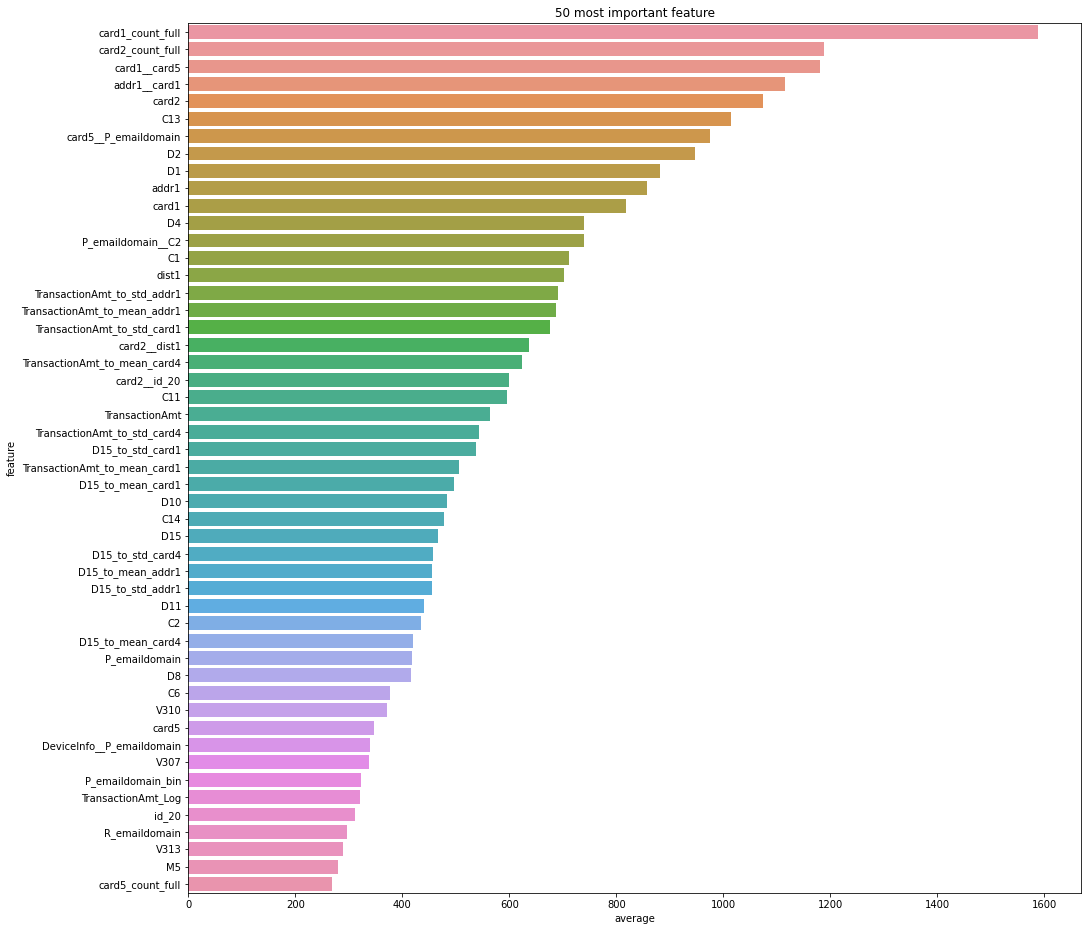

In [45]:
plt.figure(figsize=(16, 16))
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(skf.n_splits)]].mean(axis=1)
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 most important feature');

# 模型调参

In [ ]:
# TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
param_grid = {
              'learning_rate': [0.001, 0.005, 0.01],
              'feature_fraction': np.arange(0.1, 0.7, 0.3),
              'bagging_fraction': np.arange(0.2, 0.8, 0.3),
              'bagging_freq': [2, 4, 6],
              'lambda_l1': np.arange(0, 1, 0.4),
              'lambda_l2': np.arange(0, 1, 0.4)
}
print(len(ParameterGrid(parameters)))

clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         num_leaves = 35,
                        ramdom_state=47,
                        n_jobs=24)


gsearch = GridSearchCV(clf, param_grid=param_grid, scoring='roc_auc', cv=[(idxT, idxV)])
gsearch.fit(X_train, y_train)

In [ ]:
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print(gsearch.cv_results_['mean_fit_time'])

result = pd.DataFrame.from_dict(gsearch.cv_results_)
result.to_csv('./output/lgbm_params.csv')